#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
!pip install logomaker
!pip install pyBigWig

  Using cached logomaker-0.8-py2.py3-none-any.whl (11.8 MB)
You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.
  Using cached pyBigWig-0.3.22-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (217 kB)
You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler



from sklearn import metrics
import numpy as np

import prismnet.model as arch
from prismnet import train, validate, inference, log_print, compute_saliency, compute_saliency_img, compute_high_attention_region
#compute_high_attention_region

# from prismnet.engine.train_loop import 
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.loader import SeqicSHAPE
from prismnet.utils import datautils

In [3]:
import pandas as pd
outstem = 'K562_rep6'
rbp = 'RBFOX2'
motif = 'GCATG'
megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                                 'seq', 'struct', 'label', 'start'])

In [4]:
seq.head()

,chrom,name,seq,struct,label,start
0,chr1,1,ATTAATCCCCTGGCCCAACCCGTCATCTACTCTACCATCTTTGCAG...,"-1.0,-1.0,-1.0,-1.0,-1.0,0.5,0.4,0.2,0.2,0.3,0...",-1,629639
1,chr1,10,CACCCTCCTTAACCTCTACTTCTACCTGCGCCTAATCTACTCCACC...,"0.5,0.1,0.2,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.3,0....",-1,630493
2,chr1,100013,GCCCGCCTCTGCCTCCCAAAGTGCTGGGATTACAGGCCTGAGCCAC...,NaN,-1,65435609
3,chr1,100014,CCAATAGAACCAAAATATTTATGAGGATGCTAGCATTTTCCAAGCA...,NaN,-1,65435708
4,chr1,100015,TGTGCATTTTAATTTAATTCTCCTTTTTCCATTTTGTCTCATGAAG...,NaN,-1,65435808


In [5]:
max_length=seq['seq'].str.len().max()

# Evaluate training

In [6]:
# plot training curve
curve = pd.read_csv(f'../data/ABC_data/{outstem}.training_curve.csv')

type
test     AxesSubplot(0.125,0.125;0.775x0.755)
train    AxesSubplot(0.125,0.125;0.775x0.755)
Name: loss, dtype: object

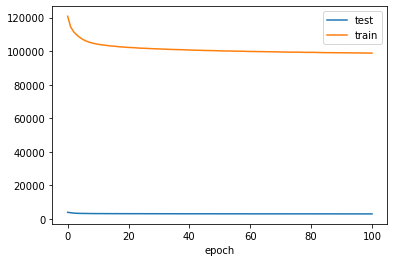

In [7]:
curve.set_index('epoch').groupby(by = 'type')['loss'].plot(legend = True)

# visualize

<AxesSubplot:>

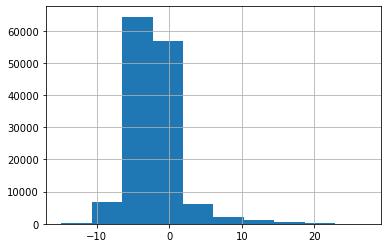

In [8]:
megaoutput[f'logLR:{outstem}.{rbp}'].hist()

In [9]:
positive = megaoutput.loc[megaoutput[f'logLR:{outstem}.{rbp}']>2]

In [10]:
positive['logLR_bin'] = pd.cut(positive[f'logLR:{outstem}.{rbp}'], bins = 5)

/tmp/ipykernel_115/4225601108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive['logLR_bin'] = pd.cut(positive[f'logLR:{outstem}.{rbp}'], bins = 5)


In [11]:
positive['logLR_bin'].value_counts()

(1.981, 7.018]      6637
(7.018, 12.029]     2135
(12.029, 17.04]     1064
(17.04, 22.052]      301
(22.052, 27.063]      51
Name: logLR_bin, dtype: int64

In [12]:
positive['gene_name'].value_counts().iloc[:20]

GSE1                             162
NEAT1                            130
CCDC200                          123
PRKCB                             80
C22orf34                          73
DGCR8                             68
RP11-719N9.1                      63
DOT1L                             50
LRCH4                             42
HBG2:CTD-2643I7.5:HBE1:OR51B5     41
EPB41                             40
DNM2                              37
UNKL                              36
PFKP                              35
SMPD4BP                           33
PIEZO1                            33
SCARB1                            32
CAMK2G                            32
PI4KAP2                           32
MIR17HG                           30
Name: gene_name, dtype: int64

In [13]:
# # only plot specific outputs
# sample_size = 64
# subset = []
# # select specific logLR as outputs
# #subset = megaoutput.loc[megaoutput[f'{outstem}.{rbp}']].sample(sample_size)
# for name,group in positive.groupby(by=['logLR_bin']):
#     try:
#         subset.append(group.sample(sample_size))
#     except:
#         subset.append(group)
# subset = pd.concat(subset, axis = 0)           
# subset[f'logLR:{outstem}.{rbp}'].hist()

In [14]:
subset = positive.loc[positive['gene_name']=='C22orf34']

In [15]:
from prismnet.utils import datautils

In [16]:
subset_seq_df = seq.set_index('name').loc[subset['name'].tolist(), ['seq']]

In [17]:
subset_seq_df.shape

(73, 1)

In [18]:
one_hot = datautils.convert_one_hot(subset_seq_df['seq'].tolist(), max_length)
one_hot.shape # N, 4, max_length

(73, 4, 100)

In [19]:
data = one_hot

In [20]:
# targets: predict binary
target_col = subset.columns[(subset.columns.str.startswith('logLR'))&(subset.columns.str.contains(outstem))]
target_df = subset[target_col]

In [21]:
targets = target_df.values
targets.shape

(73, 10)

In [22]:
train, test = datautils.split_dataset(data, targets, valid_frac=0.2)

target_data_type = np.float32

In [23]:
from prismnet.model.PrismNet import *
class PrismNet_Multitask(nn.Module):
    def __init__(self, mode="pu", output_dim=10):
        super(PrismNet_Multitask, self).__init__()
        self.mode = mode
        h_p, h_k = 2, 5 
        if mode=="pu":
            self.n_features = 5
        elif mode=="seq":
            self.n_features = 4
            h_p, h_k = 1, 3 
        elif mode=="str":
            self.n_features = 1
            h_p, h_k = 0, 1
        else:
            raise "mode error"
        
        base_channel = 8
        self.conv    = Conv2d(1, base_channel, kernel_size=(11, h_k), bn = True, same_padding=True)
        self.se      = SEBlock(base_channel)
        self.res2d   = ResidualBlock2D(base_channel, kernel_size=(11, h_k), padding=(5, h_p)) 
        self.res1d   = ResidualBlock1D(base_channel*4) 
        self.avgpool = nn.AvgPool2d((1,self.n_features))
        self.gpool   = nn.AdaptiveAvgPool1d(1)
        self.fc      = nn.Linear(base_channel*4*8, output_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, input):
        """[forward]
        
        Args:
            input ([tensor],N,C,W,H): input features
        """
        if self.mode=="seq":
            input = input[:,:,:,:4]
        elif self.mode=="str":
            input = input[:,:,:,4:]
        x = self.conv(input)
        x = F.dropout(x, 0.1, training=self.training)
        z = self.se(x)
        x = self.res2d(x*z)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.avgpool(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        x = self.res1d(x)
        x = F.dropout(x, 0.3, training=self.training)
        x = self.gpool(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(x)
        return x

In [24]:
model = PrismNet_Multitask(mode = 'seq', output_dim = targets.shape[1])
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)
model.load_state_dict(torch.load(f'../data/ABC_data/{outstem}.model.pt'))

<All keys matched successfully>

In [25]:
class SeqicSHAPE_Multitask(torch.utils.data.Dataset):
    def __init__(self, X, Y, is_infer=False, use_structure=True):
        """data loader
        
        Args:
            data_path ([str]): h5 file path
            is_test (bool, optional): testset or not. Defaults to False.
        """
        if is_infer:
            self.dataset = self.__load_infer_data__(data_path, use_structure=use_structure)
            print("infer data: ", self.__len__()," use_structure: ", use_structure)
        else:
#             dataset = h5py.File(data_path, 'r')
#             X_train = np.array(dataset['X_train']).astype(np.float32)
#             Y_train = np.array(dataset['Y_train']).astype(np.int32)
#             X_test  = np.array(dataset['X_test']).astype(np.float32)
#             Y_test  = np.array(dataset['Y_test']).astype(np.int32)
            X = np.array(X).astype(np.float32)
            Y = np.array(Y).astype(np.float32)
#             if len(Y_train.shape) == 1:
#                 Y_train = np.expand_dims(Y_train, axis=1)
#                 Y_test  = np.expand_dims(Y_test, axis=1)
            X = np.expand_dims(X, axis=3).transpose([0, 3, 2, 1]) # N, 1, length, channel
            

            

#             labels, nums = np.unique(Y_train,return_counts=True)
#             print("train:", labels, nums)
#             labels, nums = np.unique(Y_test,return_counts=True)
#             print("test:", labels, nums)

#             train = self.__prepare_data__(train)
#             test  = self.__prepare_data__(test)

            
            self.dataset = {'inputs': X, 'targets': Y}
            

        

    def __load_infer_data__(self, data_path, use_structure=True):
        from prismnet.utils import datautils
        dataset = datautils.load_testset_txt(data_path, use_structure=use_structure, seq_length=101)
        return dataset
       
    
    def __prepare_data__(self, data):
        inputs    = data['inputs'][:,:,:,:4]
        structure = data['inputs'][:,:,:,4:]
        structure = np.expand_dims(structure[:,:,:,0], axis=3)
        inputs    = np.concatenate([inputs, structure], axis=3)
        data['inputs']  = inputs
        return data

    def __to_sequence__(self, x):
        x1 = np.zeros_like(x[0,:,:1])
        for i in range(x1.shape[0]):
            # import pdb; pdb.set_trace()
            x1[i] = np.argmax(x[0,i,:4])
            # import pdb; pdb.set_trace()
        return x1

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        x = self.dataset['inputs'][index]
        # x = self.__to_sequence__(x)
        y = self.dataset['targets'][index]
        return x, y


    def __len__(self):
        return len(self.dataset['inputs'])



In [26]:
import numpy as np
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
# train_loader = torch.utils.data.DataLoader(
    
    
#     SeqicSHAPE_Multitask(train[0], train[1], is_infer=False, use_structure=False), 
# batch_size=64, shuffle=True,  **kwargs)

test_loader  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask(data, targets, is_infer=False, use_structure=False),
batch_size=64*8, shuffle=False, **kwargs)

#print("Train set:", len(train_loader.dataset)) #X_train (example=91099, ATCGshape=5, length=101)
#X_train (example=91099, ATCGshape=5, length=101)
#Y_train (example=91099, binary_outcome=1))
print("Test  set:", len(test_loader.dataset))

Test  set: 73


In [27]:
def train(model, device, train_loader, criterion, optimizer):
    ''' train for one epoch'''
    model.train()
    epoch_loss = 0
    for batch_idx, (x0, y0) in enumerate(train_loader):
        x, y = x0.float().to(device), y0.to(device).float()
        
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output, y)
        epoch_loss+=loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    return epoch_loss
def validate(model, device, test_loader, criterion):
    model.eval()
    y_all = []
    p_all = []
    l_all = []
    epoch_loss = 0
    with torch.no_grad():
        for batch_idx, (x0, y0) in enumerate(test_loader):
            x, y = x0.float().to(device), y0.to(device).float()
            
            
            output  = model(x)
            loss = criterion(output, y)
            
            epoch_loss += loss.item()
            y_np = output.to(device='cpu', dtype=torch.float32).numpy()
            y_all.append(y_np)
            

    return epoch_loss, y_all

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-6)
nepoch = 60
scheduler = GradualWarmupScheduler(
    optimizer, multiplier=8, total_epoch=nepoch, after_scheduler=None)
criterion = torch.nn.MSELoss()
batch_size= 64

In [29]:
loss_test, y_test_pred = validate(model, device, test_loader, criterion)

In [30]:
test[0].shape

(145, 4, 100)

(-0.21668258282281105, 0.08547011781411336)


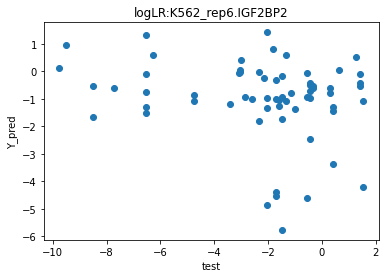

(-0.09011214097415766, 0.4788636361968615)


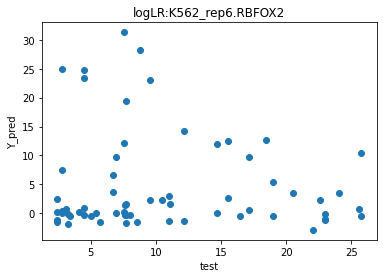

(-0.19316796504566142, 0.12618269105542768)


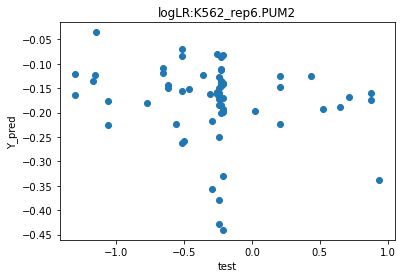

(-0.018419613322074452, 0.8851334257557231)


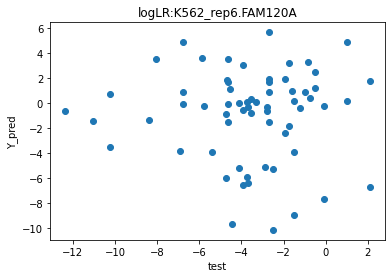

(-0.09546659389639503, 0.45301592539757335)


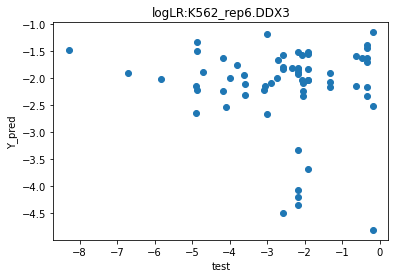

(0.05237933618438974, 0.681029835390644)


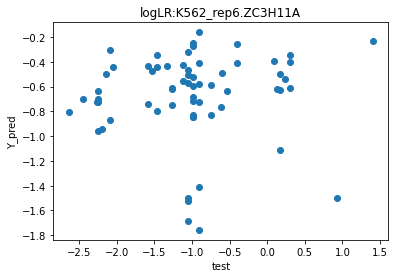

(-0.039791937695903265, 0.7548999032531852)


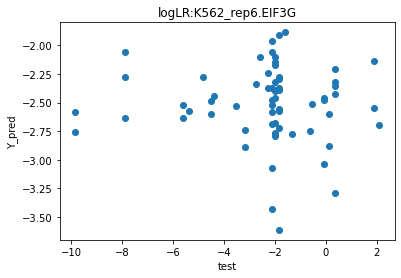

(-0.12266752820144916, 0.334218332231403)


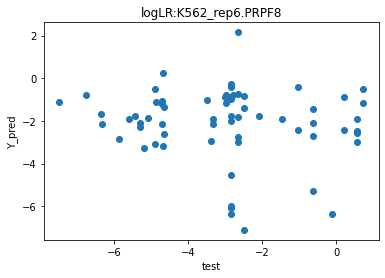

(-0.06512495672411928, 0.6091588760737328)


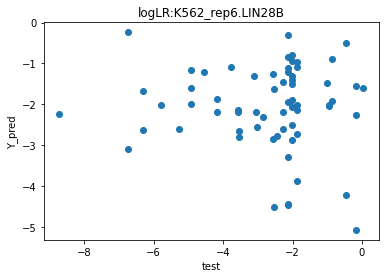

(-0.0694640446453132, 0.5854652024687147)


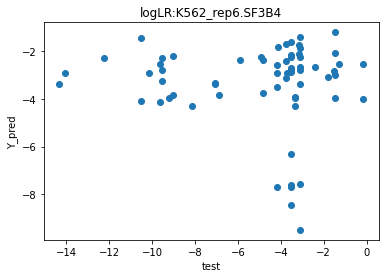

In [31]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
y_pred=np.concatenate(y_test_pred)
for rbp_idx, name in zip(range(test[1].shape[1]), target_df.columns):
    plt.scatter(test[1][:64, rbp_idx], y_pred[:64, rbp_idx])
    plt.ylabel('Y_pred')
    plt.xlabel('test')
    print(pearsonr(test[1][:64, rbp_idx],y_pred[:64, rbp_idx]))
    plt.title(name)
    plt.show()
    

In [32]:
#!/usr/bin/env python
# 
# Kui Xu, xukui.cs@gmail.com
# 2019-02-25
# ref smoothGrad

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad,Variable
import numpy as np

class SmoothGrad(object):
    def __init__(self, model, device='cpu', only_seq=False, train=False, 
        x_stddev=0.015, t_stddev=0.015, nsamples=20, magnitude=2):
        self.model     = model
        self.device    = device
        self.train     = train
        self.only_seq  = only_seq
        self.x_stddev  = x_stddev
        self.t_stddev  = t_stddev
        self.nsamples  = nsamples
        self.magnitude = magnitude
        self.features  = model
        # import pdb; pdb.set_trace()

    def get_gradients(self, z, pred_label=None, rbp_idx = 0):
        self.model.eval()
        self.model.zero_grad()
        z = z.to(self.device)
        z.requires_grad=True
        output = self.model(z)
        
        output[:,rbp_idx].backward() # now it is a multioutput.... maybe sum is not the right way tho!
        return z.grad

    def get_smooth_gradients(self, z, y=None, rbp_idx=0):
        return self.__call__(z, y, rbp_idx = rbp_idx)
        
    def __call__(self, z, y=None,rbp_idx = 0):
        """[summary]
        
        Args:
            z ([type]): [description] X
            y ([type]): [description] Y
            x_stddev (float, optional): [description]. Defaults to 0.15.
            t_stddev (float, optional): [description]. Defaults to 0.15.
            nsamples (int, optional):   [description]. Defaults to 20.
            magnitude (int, optional):  magnitude:0,1,2; 0: original gradient, 1: absolute value of the gradient,
                                        2: square value of the gradient. Defaults to 2.
        
        Returns:
            [type]: [description]
        """

        # 1. for sequece
        x = z[:,:,:,:4] # .data.cpu()
        x_stddev   = (self.x_stddev * (x.max()-x.min())).to(self.device).item() 

        total_grad = torch.zeros(z.shape).to(self.device)
        x_noise    = torch.zeros(x.shape).to(self.device)
        if not self.only_seq:
            # 2. for structure  
            t = z[:,:,:,4:] #.data.cpu()
            t_stddev = (self.t_stddev * (t.max()-t.min())).to(self.device).item() 
            #t_total_grad = torch.zeros(t.shape)
            t_noise = torch.zeros(t.shape).to(self.device)

        for i in range(self.nsamples):
            x_plus_noise = x + x_noise.zero_().normal_(0, x_stddev)
            if self.only_seq:
                z_plus_noise = x_plus_noise
            else:
                t_plus_noise = t + t_noise.zero_().normal_(0, t_stddev)
                z_plus_noise = torch.cat((x_plus_noise, t_plus_noise), dim=3)
            #print("z_plus_noise:",z_plus_noise.size())
            grad = self.get_gradients(z_plus_noise, y, rbp_idx = rbp_idx)
            if self.magnitude == 1:
                total_grad += torch.abs(grad)
            elif self.magnitude == 2:
                total_grad += grad * grad
            
            # total_grad += grad * grad
        total_grad /= self.nsamples
        return total_grad

    def get_batch_gradients(self, X, Y=None, rbp_idx = 0):
        if Y is not None:
            assert len(X) == len(Y), "The size of input {} and target {} are not matched.".format(len(X), len(Y))
        g = torch.zeros_like(X)
        for i in range(X.shape[0]):
            x        = X[i:i+1]
            if Y is not None:
                y    = Y[i:i+1]
            else:
                y    = None
            g[i:i+1] =  self.get_smooth_gradients(x, y, rbp_idx = rbp_idx)
            # g[i:i+1] =  self.get_gradients(x, y)
        return g


def generate_saliency(model, x, y=None, smooth=False, nsamples=2, stddev=0.15, only_seq=False, \
    train=False):
    saliency = SmoothGrad(model, only_seq, train)
    x_grad   = saliency.get_smooth_gradients(x, y, nsamples=nsamples, x_stddev=stddev, t_stddev=stddev)
    return x_grad



class GuidedBackpropReLU(torch.autograd.Function):

    def __init__(self, inplace=False):
        super(GuidedBackpropReLU, self).__init__()
        self.inplace = inplace

    def forward(self, input):
        pos_mask = (input > 0).type_as(input)
        output = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            input,
            pos_mask)
        self.save_for_backward(input, output)
        return output

    def backward(self, grad_output):
        input, output = self.saved_tensors

        pos_mask_1 = (input > 0).type_as(grad_output)
        pos_mask_2 = (grad_output > 0).type_as(grad_output)
        grad_input = torch.addcmul(
            torch.zeros(input.size()).type_as(input),
            torch.addcmul(
                torch.zeros(input.size()).type_as(input), grad_output, pos_mask_1),
                pos_mask_2)

        return grad_input

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' (' \
            + inplace_str + ')'

class GuidedBackpropSmoothGrad(SmoothGrad):

    def __init__(self, model, device='cpu', only_seq=False, train=False, 
        x_stddev=0.15, t_stddev=0.15, nsamples=20, magnitude=2):
        super(GuidedBackpropSmoothGrad, self).__init__(
            model, device, only_seq, train, x_stddev, t_stddev, nsamples, magnitude)
        for idx, module in self.features._modules.items():
            if module.__class__.__name__ is 'ReLU':
                self.features._modules[idx] = GuidedBackpropReLU()



<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_115/2063606002.py:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if module.__class__.__name__ is 'ReLU':


In [33]:

model.eval()
sgrad = GuidedBackpropSmoothGrad(model, device=device, only_seq = True)

In [34]:
rbp_idx = 1
for batch_idx, (x0, y0) in enumerate(test_loader):
    X, Y = x0.float().to(device), y0.to(device).float()
    output = model(X)
    
    guided_saliency = sgrad.get_batch_gradients(X, Y, rbp_idx = rbp_idx)
    break

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [35]:
guided_saliency.shape

torch.Size([73, 1, 100, 4])

In [36]:
# dot product of sequence and guided saliency
max_saliency = (np.transpose(np.expand_dims(one_hot, axis =1), (0,1,3,2))*guided_saliency.cpu().numpy()
               ).sum(axis = -1).max(axis = -1).squeeze(-1)

In [37]:
subset_seq_df['is_motif']=subset_seq_df['seq'].str.contains(motif)
subset_seq_df['n_motif']=subset_seq_df['seq'].str.count(motif)
subset_seq_df['max_saliency'] = max_saliency
subset_seq_df[f'logLR:{outstem}.{rbp}'] = subset.set_index('name')[f'logLR:{outstem}.{rbp}']
subset_seq_df['rbp_idx'] = np.arange(subset_seq_df.shape[0])

In [38]:
secondary_motif = ['GCACG', 'GCUUG', 'GAAUG', 'GUUUG', 'GUAUG', 'GUGUG', 'GCCUG']
for m in secondary_motif:
    subset_seq_df[f'is_{m}']=subset_seq_df['seq'].str.contains(m)


In [39]:
subset_seq_df.index.tolist()==subset['name'].tolist()

True

array([<AxesSubplot:title={'center':'max_saliency'}, xlabel='is_motif'>,
       <AxesSubplot:title={'center':'logLR:K562_rep6.RBFOX2'}, xlabel='is_motif'>],
      dtype=object)

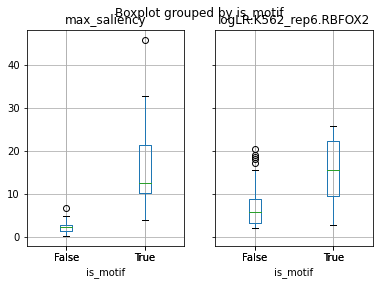

In [40]:
subset_seq_df.boxplot(by = 'is_motif', column = ['max_saliency', f'logLR:{outstem}.{rbp}'])

In [41]:
subset_seq_df.loc[(subset_seq_df['is_motif'])].sort_values(by = 'n_motif')

,seq,is_motif,n_motif,max_saliency,logLR:K562_rep6.RBFOX2,rbp_idx,is_GCACG,is_GCUUG,is_GAAUG,is_GUUUG,is_GUAUG,is_GUGUG,is_GCCUG
name,,,,,,,,,,,,,
5679840,AACACCAGTTTGGACAGTGCTCTGAAGGTGTTGTGTAGATATGCTT...,True,1,6.770856,7.687904,0,False,False,False,False,False,False,False
5681681,TAGAGACACACCCGTAATATACACAAATGGGCACACACATGCATGT...,True,1,14.521306,19.009739,51,False,False,False,False,False,False,False
5681680,ACATACACGGGCACACATGTACAGACACCCATAATATACACACATG...,True,1,8.339869,17.123624,50,False,False,False,False,False,False,False
5681679,ACATGTACAGACACACCCATAATATACACACATGGACACACATGTA...,True,1,9.937978,14.049841,49,False,False,False,False,False,False,False
5681678,CCATAATGTGCACACACAGGCACACACATGCATATACAGGCACACC...,True,1,11.775274,17.556363,48,True,False,False,False,False,False,False
5681647,GAACGAAATTTACGGGCCCACAGTTCTGGAGGCTGGAAAGTCCAAG...,True,1,4.005956,8.932297,45,False,False,False,False,False,False,False
5680898,AACACAGCCTTGATTATGGGTTACATGATCCATAGGTAAACCGTGA...,True,1,45.845768,2.776091,36,False,False,False,False,False,False,False
5681684,AATAATTAGATGAGCTGACGGTGCCGCAGCACATGGCATTTGTTAG...,True,1,10.926226,4.107711,54,False,False,False,False,False,False,False
5680836,CCTATGTCACGCATCGTGAGTGTACACAGAGCTTGGTGCCTGCACA...,True,1,27.426813,22.949096,13,False,False,False,False,False,False,False


In [42]:
subset_seq_df.loc[(subset_seq_df['max_saliency']>5)&(~subset_seq_df['is_motif'])]

,seq,is_motif,n_motif,max_saliency,logLR:K562_rep6.RBFOX2,rbp_idx,is_GCACG,is_GCUUG,is_GAAUG,is_GUUUG,is_GUAUG,is_GUGUG,is_GCCUG
name,,,,,,,,,,,,,
5681865,TGCACCCCAGCCTCCCTGCTCCAGCCCAGTGCTGTTTGTTCTGTGA...,False,0,6.695062,6.917269,58,True,False,False,False,False,False,False


In [43]:
import pyBigWig
import numpy as np

class strand_specific_wig:
    def __init__(self, plus, minus):
        self.plus = pyBigWig.open(plus)
        self.minus = pyBigWig.open(minus)
        
    def fetch(self, chrom = None, start= None, end=None, strand= None, interval = None):
        ''' return icSHAPE reacitivity for a bedtool interval or chrom, start, end, strand'''
        if interval:
            start = interval.start
            end = interval.end
            strand = interval.strand
            chrom = interval.chrom
        if strand == '-':
            icshape_data = self.minus
        else:
            icshape_data = self.plus
        values = icshape_data.values(chrom, start, end)
        if strand == '-':
            values = values[::-1]
        return np.nan_to_num(np.array(values), 0)

In [44]:
rbp_wig_cits = strand_specific_wig(f'../data/CITS/{rbp}.pos.bw',
                                 f'../data/CITS/{rbp}.neg.bw'
                                 )
rbp_wig_cov = strand_specific_wig(f'../data/COV/{rbp}.pos.bw',
                             f'../data/COV/{rbp}.neg.bw'
                             )

In [45]:
subset_seq_df = subset_seq_df.merge(megaoutput[['name','gene_name', 'feature_type_top', 'start']], left_index = True,
                    right_on = 'name')

In [46]:
import seaborn as sns
import logomaker
from scipy.ndimage import gaussian_filter1d

def plot_saliency(index):
    index2seq = 'ACGU'
    

    # find coverage
    window_name = subset_seq_df.loc[subset_seq_df['rbp_idx']==index, 'name'].values[0]
    row = megaoutput.loc[megaoutput['name']==window_name].iloc[0]
    wig_values = rbp_wig_cov.fetch(row['chrom'], row['start'], row['end'], row['strand'])
    wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])

    seq_values = one_hot[index,:,:] # [1,4,100]
    gradient_values = guided_saliency[index,0,:,:].cpu().numpy() # [1,1,100,4]
    saliency_values = gradient_values * seq_values.T # 4*100
    saliency_df = pd.DataFrame(saliency_values.T)
    saliency_df.index = list(index2seq)

    saliency_df = saliency_df.loc[:, seq_values.sum(axis = 0)!=0].T
    saliency_df.index = np.arange(saliency_df.shape[0])

    f, ax = plt.subplots(2,1, sharex = True, figsize = (12,4))
    logomaker.Logo(saliency_df, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[0])


    ax[0].set_ylabel('saliency')
    ax[1].bar(np.arange(len(wig_values)), wig_values, color = 'lightgrey')
    ax[1].set_ylabel('coverage')
#     ax[2].bar(np.arange(len(wig_values_cits)), wig_values_cits, color = 'lightgrey')
#     ax[2].plot(gaussian_filter1d(wig_values_cits, 3), color = 'tomato', label = 'smoothed CITS')
#     ax[2].set_ylabel('#CITS')

    ax[0].set_title(row['chrom'] + ':'+str(row['start'])+'-'+str(row['end'])+':'+row['strand'])
    sns.despine()

Unable to revert mtime: /opt/conda/fonts


In [47]:
subset_seq_df

,seq,is_motif,n_motif,max_saliency,logLR:K562_rep6.RBFOX2,rbp_idx,is_GCACG,is_GCUUG,is_GAAUG,is_GUUUG,is_GUAUG,is_GUGUG,is_GCCUG,name,gene_name,feature_type_top,start
125456,AACACCAGTTTGGACAGTGCTCTGAAGGTGTTGTGTAGATATGCTT...,True,1,6.770856,7.687904,0,False,False,False,False,False,False,False,5679840,C22orf34,INTRON,49426806
125457,ACATGGACACACACATATGCATACACATGCATGCACGCACACACAC...,True,1,22.346189,7.527637,1,True,False,False,False,False,False,False,5679843,C22orf34,INTRON,49427105
125459,CCAGCCCCTCCCAGACAGCACTTGGCTCTCTAAGACACCTGCTCGG...,False,0,3.824937,12.997354,2,False,False,False,False,False,False,False,5680131,C22orf34,INTRON,49455811
125460,CTGGGGCTGTATTTTATTCAGAGACCTCAGAAAAATAACACACATG...,True,1,10.075552,3.397599,3,True,False,False,False,False,False,False,5680213,C22orf34,INTRON,49464011
125462,GGGGTAAAATCACAGGGGGTGGAAGCTGAGGTAGCTGGAAAATGGG...,False,0,2.267336,8.570732,4,False,False,False,False,False,False,False,5680710,C22orf34,INTRON,49513709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125563,AGCCCGGGGCCAGCTTCACAGCCGGACATCCAGACAGAGCCCTGTG...,False,0,0.667917,3.223329,68,False,False,False,False,False,False,False,5681941,C22orf34,INTRON,49636804
125565,GTTGGGTGGTGTTGGATGAGGCTGGGCTGATCATTCAGGGAGCTGA...,False,0,2.094129,2.869546,69,False,False,False,False,False,False,False,5681955,C22orf34,INTRON,49638204
125567,ACTCTGGGGGCTGGGGGCCCTGCACGTGGCTCACTCTGGGTAAGGA...,False,0,4.791893,5.687006,70,True,False,False,False,False,False,False,5681972,C22orf34,INTRON,49639904
125568,TCCTGTGTTGGCTCAGTGGCAGTCTCCACGCTGTGTCCTAGAGGGT...,False,0,1.897733,3.223329,71,False,False,False,False,False,False,False,5681977,C22orf34,INTRON,49640404


In [48]:
subset_seq_df['gene_name'].value_counts()

C22orf34    73
Name: gene_name, dtype: int64

In [49]:
subset_seq_df.loc[subset_seq_df['gene_name']=='C22orf34']

,seq,is_motif,n_motif,max_saliency,logLR:K562_rep6.RBFOX2,rbp_idx,is_GCACG,is_GCUUG,is_GAAUG,is_GUUUG,is_GUAUG,is_GUGUG,is_GCCUG,name,gene_name,feature_type_top,start
125456,AACACCAGTTTGGACAGTGCTCTGAAGGTGTTGTGTAGATATGCTT...,True,1,6.770856,7.687904,0,False,False,False,False,False,False,False,5679840,C22orf34,INTRON,49426806
125457,ACATGGACACACACATATGCATACACATGCATGCACGCACACACAC...,True,1,22.346189,7.527637,1,True,False,False,False,False,False,False,5679843,C22orf34,INTRON,49427105
125459,CCAGCCCCTCCCAGACAGCACTTGGCTCTCTAAGACACCTGCTCGG...,False,0,3.824937,12.997354,2,False,False,False,False,False,False,False,5680131,C22orf34,INTRON,49455811
125460,CTGGGGCTGTATTTTATTCAGAGACCTCAGAAAAATAACACACATG...,True,1,10.075552,3.397599,3,True,False,False,False,False,False,False,5680213,C22orf34,INTRON,49464011
125462,GGGGTAAAATCACAGGGGGTGGAAGCTGAGGTAGCTGGAAAATGGG...,False,0,2.267336,8.570732,4,False,False,False,False,False,False,False,5680710,C22orf34,INTRON,49513709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125563,AGCCCGGGGCCAGCTTCACAGCCGGACATCCAGACAGAGCCCTGTG...,False,0,0.667917,3.223329,68,False,False,False,False,False,False,False,5681941,C22orf34,INTRON,49636804
125565,GTTGGGTGGTGTTGGATGAGGCTGGGCTGATCATTCAGGGAGCTGA...,False,0,2.094129,2.869546,69,False,False,False,False,False,False,False,5681955,C22orf34,INTRON,49638204
125567,ACTCTGGGGGCTGGGGGCCCTGCACGTGGCTCACTCTGGGTAAGGA...,False,0,4.791893,5.687006,70,True,False,False,False,False,False,False,5681972,C22orf34,INTRON,49639904
125568,TCCTGTGTTGGCTCAGTGGCAGTCTCCACGCTGTGTCCTAGAGGGT...,False,0,1.897733,3.223329,71,False,False,False,False,False,False,False,5681977,C22orf34,INTRON,49640404


In [50]:
subset_seq_df['feature_type_top'].value_counts()

INTRON    73
Name: feature_type_top, dtype: int64

<AxesSubplot:xlabel='start', ylabel='logLR:K562_rep6.RBFOX2'>

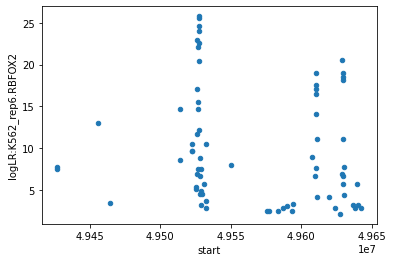

In [51]:
subset_seq_df.plot.scatter(x = 'start', y = f'logLR:{outstem}.RBFOX2')

In [52]:
 subset_seq_df.loc[subset_seq_df['gene_name']=='C22orf34'].sort_values(by = f'logLR:{outstem}.RBFOX2')

,seq,is_motif,n_motif,max_saliency,logLR:K562_rep6.RBFOX2,rbp_idx,is_GCACG,is_GCUUG,is_GAAUG,is_GUUUG,is_GUAUG,is_GUGUG,is_GCCUG,name,gene_name,feature_type_top,start
125545,CCCCTGAGTTCCCTGGCAGGGATGACCCATGTTCCTGGGCGGTGCC...,False,0,2.470832,2.102203,57,False,False,False,False,False,False,False,5681849,C22orf34,INTRON,49627605
125515,GGATTTCCTCCTGAAGATGCATTGTGCCTTCAGTGGGGAAGCTAGG...,False,0,4.132022,2.418185,43,False,False,False,False,False,False,False,5681510,C22orf34,INTRON,49593706
125511,GGAGTCTCGGCTGTGCTGCTTGTCACCTTTAAACAGTCTGGACACT...,False,0,2.652842,2.418185,40,False,False,False,False,False,False,False,5681410,C22orf34,INTRON,49583706
125508,GTCACAGTCTGCAAAACATTTAGGATCCTAAACATAAGAGAAAAAG...,False,0,0.157365,2.418185,39,False,False,False,False,False,False,False,5681344,C22orf34,INTRON,49577106
125506,ACAGGCCTGGTCCTGGGGAAAGAGCGCAGCCCTCAGCACAGTCCTT...,False,0,0.617674,2.418185,38,False,False,False,False,False,False,False,5681331,C22orf34,INTRON,49575807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125474,CCTATGTCACGCATCGTGAGTGTACACAGAGCTTGGTGCCTGCACA...,True,1,27.426813,22.949096,13,False,False,False,False,False,False,False,5680836,C22orf34,INTRON,49526308
125481,TGCATCTGCATGTTTGTGCTTCTGTGCATGTTTGTGCGTCTGTGTG...,True,5,14.694696,24.063398,20,False,False,False,False,False,False,False,5680846,C22orf34,INTRON,49527308
125485,TGTCTGTGCATGTGTGTGCGTGTGCCCATGCGCAGGCTTATGTCTG...,True,4,11.947450,24.588403,24,False,False,False,False,False,False,False,5680850,C22orf34,INTRON,49527708
125482,CATGTTTGTGTGTCTGTGTGCATGTTTGTGTATCTGCATGTTTGTG...,True,4,32.437328,25.578180,21,False,False,False,False,False,False,False,5680847,C22orf34,INTRON,49527408


findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


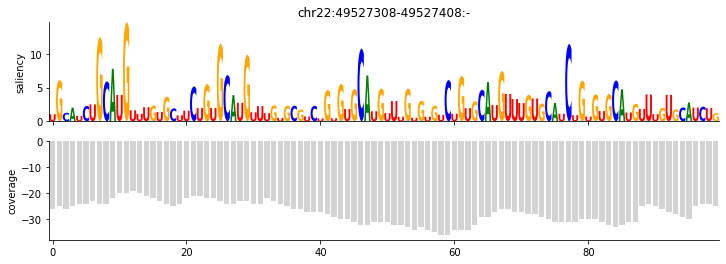

In [53]:
plot_saliency(20)

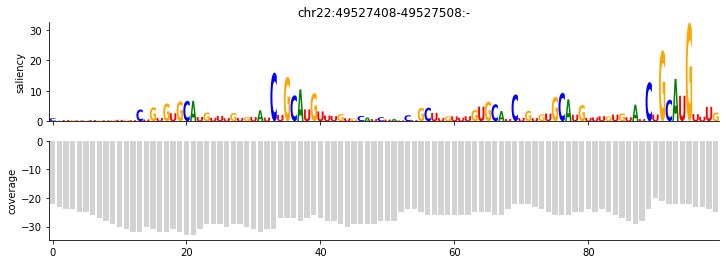

In [54]:
plot_saliency(21)

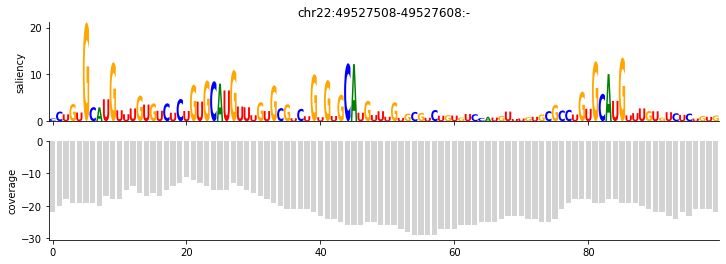

In [55]:
plot_saliency(22)

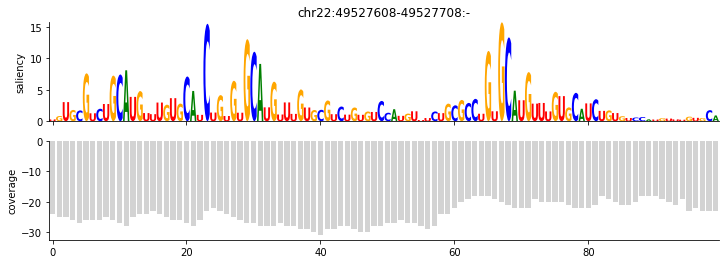

In [56]:
plot_saliency(23)

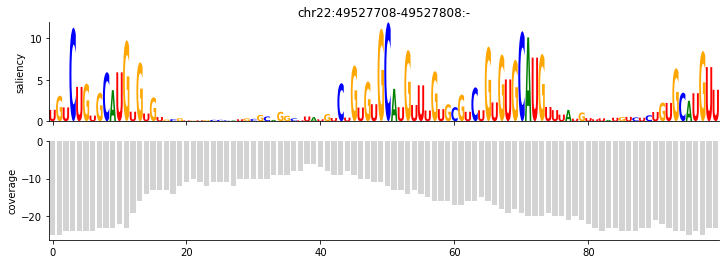

In [57]:
plot_saliency(24)

In [58]:
def plot_saliency(indices):
    index2seq = 'ACGU'
    

    # find coverage
    all_wig_value = []
    all_saliency_values = []
    window_names = subset_seq_df.loc[subset_seq_df['rbp_idx'].isin(indices), 'name']
    sub = megaoutput.loc[megaoutput['name'].isin(window_names)].iloc[0]
    for index in indices:
        window_name = subset_seq_df.loc[subset_seq_df['rbp_idx']==index, 'name'].values[0]
        row = megaoutput.loc[megaoutput['name']==window_name].iloc[0]
        wig_values = rbp_wig_cov.fetch(row['chrom'], row['start'], row['end'], row['strand'])
        wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])

        seq_values = one_hot[index,:,:] # [1,4,100]
        gradient_values = guided_saliency[index,0,:,:].cpu().numpy() # [1,1,100,4]
        saliency_values = gradient_values * seq_values.T # 4*100
        saliency_df = pd.DataFrame(saliency_values.T)
        saliency_df.index = list(index2seq)

        saliency_df = saliency_df.loc[:, seq_values.sum(axis = 0)!=0].T
        saliency_df.index = np.arange(saliency_df.shape[0])
        
        all_wig_value.append(wig_values)
        all_saliency_values.append(saliency_df)
        
    
    all_wig_value = np.concatenate(all_wig_value)
    all_saliency_df = pd.concat(all_saliency_values, axis = 0, ignore_index = True)
    print(all_saliency_df)
    
    f, ax = plt.subplots(2,1, sharex = True, figsize = (60,4))
    logomaker.Logo(all_saliency_df, # only plot places with sequence
                              shade_below=.5,
                              fade_below=.5,
                              font_name='Arial Rounded MT Bold', 
                  ax = ax[0])


    ax[0].set_ylabel('saliency')
    ax[1].bar(np.arange(len(all_wig_value)), all_wig_value, color = 'lightgrey')
    ax[1].set_ylabel('coverage')
    

    ax[0].set_title(row['chrom'] + ':'+str(sub['start'].min())+'-'+str(sub['end'].max())+':'+row['strand'])
    sns.despine()

            A        C          G         U
0    0.000000  0.00000   0.000000  1.025870
1    0.000000  0.00000   6.099309  0.000000
2    0.000000  1.25661   0.000000  0.000000
3    2.015038  0.00000   0.000000  0.000000
4    0.000000  0.00000   0.000000  0.787118
..        ...      ...        ...       ...
195  0.000000  0.00000  32.437328  0.000000
196  0.000000  0.00000   0.000000  2.306863
197  0.000000  0.00000   0.000000  1.458072
198  0.000000  0.00000   0.000000  4.720290
199  0.000000  0.00000   2.840872  0.000000

[200 rows x 4 columns]


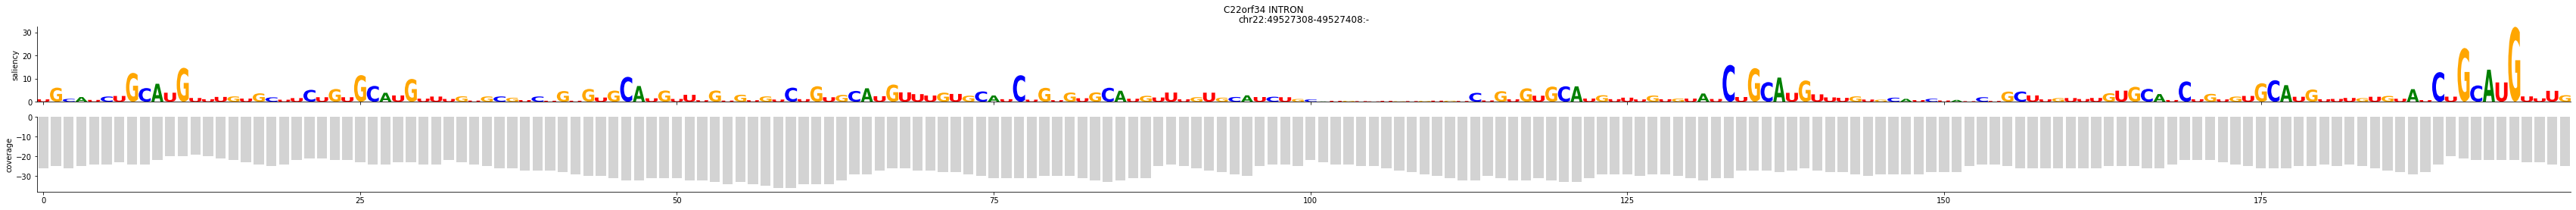

In [61]:
plt.rcParams['pdf.fonttype'] = 42
plot_saliency([20,21])
plt.suptitle('C22orf34 INTRON')
plt.savefig('C22orf34_RBFOX2.pdf')

            A         C         G         U
0    0.000000  0.574435  0.000000  0.000000
1    0.000000  2.066050  0.000000  0.000000
2    0.000000  0.000000  0.000000  1.470813
3    0.000000  0.000000  3.677982  0.000000
4    0.000000  0.000000  0.000000  1.853727
..        ...       ...       ...       ...
195  0.000000  0.000000  0.718826  0.000000
196  0.000000  0.000000  0.000000  0.532313
197  0.000000  0.000000  0.506107  0.000000
198  0.000000  1.753877  0.000000  0.000000
199  0.914112  0.000000  0.000000  0.000000

[200 rows x 4 columns]


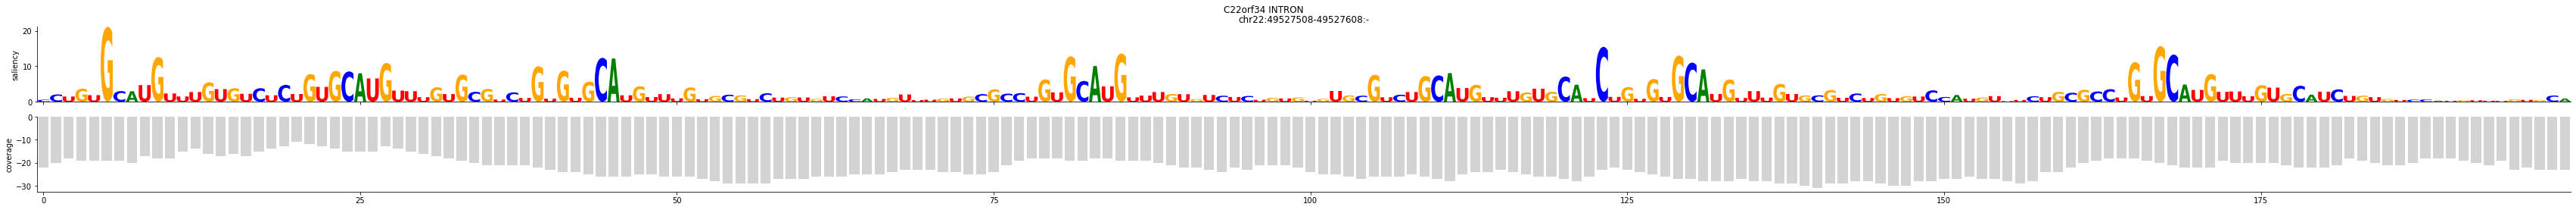

In [62]:
plt.rcParams['pdf.fonttype'] = 42
plot_saliency([22,23])
plt.suptitle('C22orf34 INTRON')
plt.savefig('C22orf34_RBFOX2_2.pdf')